# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Extract Big Mountain Data](#4.5_Extract_Big_Mountain_Data)
  * [4.6 Train/Test Split](#4.6_Train/Test_Split)
  * [4.7 Initial Not-Even-A-Model](#4.7_Initial_Not-Even-A-Model)
    * [4.7.1 Metrics](#4.7.1_Metrics)
      * [4.7.1.1 R-squared, or coefficient of determination](#4.7.1.1_R-squared,_or_coefficient_of_determination)
      * [4.7.1.2 Mean Absolute Error](#4.7.1.2_Mean_Absolute_Error)
      * [4.7.1.3 Mean Squared Error](#4.7.1.3_Mean_Squared_Error)
    * [4.7.2 sklearn metrics](#4.7.2_sklearn_metrics)
        * [4.7.2.0.1 R-squared](#4.7.2.0.1_R-squared)
        * [4.7.2.0.2 Mean absolute error](#4.7.2.0.2_Mean_absolute_error)
        * [4.7.2.0.3 Mean squared error](#4.7.2.0.3_Mean_squared_error)
    * [4.7.3 Note On Calculating Metrics](#4.7.3_Note_On_Calculating_Metrics)
  * [4.8 Initial Models](#4.8_Initial_Models)
    * [4.8.1 Imputing missing feature (predictor) values](#4.8.1_Imputing_missing_feature_(predictor)_values)
      * [4.8.1.1 Impute missing values with median](#4.8.1.1_Impute_missing_values_with_median)
        * [4.8.1.1.1 Learn the values to impute from the train set](#4.8.1.1.1_Learn_the_values_to_impute_from_the_train_set)
        * [4.8.1.1.2 Apply the imputation to both train and test splits](#4.8.1.1.2_Apply_the_imputation_to_both_train_and_test_splits)
        * [4.8.1.1.3 Scale the data](#4.8.1.1.3_Scale_the_data)
        * [4.8.1.1.4 Train the model on the train split](#4.8.1.1.4_Train_the_model_on_the_train_split)
        * [4.8.1.1.5 Make predictions using the model on both train and test splits](#4.8.1.1.5_Make_predictions_using_the_model_on_both_train_and_test_splits)
        * [4.8.1.1.6 Assess model performance](#4.8.1.1.6_Assess_model_performance)
      * [4.8.1.2 Impute missing values with the mean](#4.8.1.2_Impute_missing_values_with_the_mean)
        * [4.8.1.2.1 Learn the values to impute from the train set](#4.8.1.2.1_Learn_the_values_to_impute_from_the_train_set)
        * [4.8.1.2.2 Apply the imputation to both train and test splits](#4.8.1.2.2_Apply_the_imputation_to_both_train_and_test_splits)
        * [4.8.1.2.3 Scale the data](#4.8.1.2.3_Scale_the_data)
        * [4.8.1.2.4 Train the model on the train split](#4.8.1.2.4_Train_the_model_on_the_train_split)
        * [4.8.1.2.5 Make predictions using the model on both train and test splits](#4.8.1.2.5_Make_predictions_using_the_model_on_both_train_and_test_splits)
        * [4.8.1.2.6 Assess model performance](#4.8.1.2.6_Assess_model_performance)
    * [4.8.2 Pipelines](#4.8.2_Pipelines)
      * [4.8.2.1 Define the pipeline](#4.8.2.1_Define_the_pipeline)
      * [4.8.2.2 Fit the pipeline](#4.8.2.2_Fit_the_pipeline)
      * [4.8.2.3 Make predictions on the train and test sets](#4.8.2.3_Make_predictions_on_the_train_and_test_sets)
      * [4.8.2.4 Assess performance](#4.8.2.4_Assess_performance)
  * [4.9 Refining The Linear Model](#4.9_Refining_The_Linear_Model)
    * [4.9.1 Define the pipeline](#4.9.1_Define_the_pipeline)
    * [4.9.2 Fit the pipeline](#4.9.2_Fit_the_pipeline)
    * [4.9.3 Assess performance on the train and test set](#4.9.3_Assess_performance_on_the_train_and_test_set)
    * [4.9.4 Define a new pipeline to select a different number of features](#4.9.4_Define_a_new_pipeline_to_select_a_different_number_of_features)
    * [4.9.5 Fit the pipeline](#4.9.5_Fit_the_pipeline)
    * [4.9.6 Assess performance on train and test data](#4.9.6_Assess_performance_on_train_and_test_data)
    * [4.9.7 Assessing performance using cross-validation](#4.9.7_Assessing_performance_using_cross-validation)
    * [4.9.8 Hyperparameter search using GridSearchCV](#4.9.8_Hyperparameter_search_using_GridSearchCV)
  * [4.10 Random Forest Model](#4.10_Random_Forest_Model)
    * [4.10.1 Define the pipeline](#4.10.1_Define_the_pipeline)
    * [4.10.2 Fit and assess performance using cross-validation](#4.10.2_Fit_and_assess_performance_using_cross-validation)
    * [4.10.3 Hyperparameter search using GridSearchCV](#4.10.3_Hyperparameter_search_using_GridSearchCV)
  * [4.11 Final Model Selection](#4.11_Final_Model_Selection)
    * [4.11.1 Linear regression model performance](#4.11.1_Linear_regression_model_performance)
    * [4.11.2 Random forest regression model performance](#4.11.2_Random_forest_regression_model_performance)
    * [4.11.3 Conclusion](#4.11.3_Conclusion)
  * [4.12 Data quantity assessment](#4.12_Data_quantity_assessment)
  * [4.13 Save best model object from pipeline](#4.13_Save_best_model_object_from_pipeline)
  * [4.14 Summary](#4.14_Summary)


## 4.2 Introduction<a id='4.2_Introduction'></a>

We are ready to proceed with testing out different classifier models with our prefume feature set.

We expect the ML models to predict the gender that would prefer a perfume given the notes in that perfume.

## 4.3 Imports<a id='4.3_Imports'></a>

In [27]:
import pandas as pd
import numpy as np
import os
import pickle
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_regression

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [2]:
perfume_data = pd.read_csv('../data/processed/perfume_data_step3_features.csv')
df = perfume_data.copy()
df.head().T

,0,1,2,3,4
musk,0,1,0,0,0
sandalwood,1,0,1,0,1
jasmine,0,0,0,0,0
amber,1,1,0,0,1
patchouli,0,0,0,0,0
...,...,...,...,...,...
sea_salt,0,0,0,0,0
rice,0,0,0,0,0
red_rose,0,0,0,0,0
other_notes,1,0,0,0,0


In [3]:
df.shape

(47648, 301)

#### Scale Data using PCA

In [4]:
# Select the columns
notes_columns = df.iloc[:,:-1]
notes_columns

,musk,sandalwood,jasmine,amber,patchouli,rose,vanilla,cedar,bergamot,vetiver,...,pink_peony,exotic_woods,fennel,white_lily,tomato_leaf,clover,sea_salt,rice,red_rose,other_notes
0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47643,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47644,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47645,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47646,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
notes_pca = PCA().fit(notes_columns)
print(notes_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


In [6]:
print(notes_pca)
notes_pca.explained_variance_ratio_.cumsum()[0:100]

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


array([0.0804832 , 0.1364319 , 0.1710333 , 0.20300796, 0.23074793,
       0.25771136, 0.28347223, 0.30750411, 0.32936958, 0.34844006,
       0.36475679, 0.37919775, 0.39308492, 0.40604428, 0.41817199,
       0.42986704, 0.44137458, 0.45241748, 0.46260852, 0.47275061,
       0.48259756, 0.49228096, 0.50131104, 0.50992998, 0.51848851,
       0.52665036, 0.5347182 , 0.54256253, 0.55024285, 0.55776002,
       0.56494405, 0.5719246 , 0.57875832, 0.58544397, 0.59207964,
       0.59851552, 0.60485107, 0.6111127 , 0.61720019, 0.62327688,
       0.62904388, 0.63473929, 0.64016574, 0.6455205 , 0.65079018,
       0.65600395, 0.66112767, 0.66597454, 0.67077224, 0.67547124,
       0.68006592, 0.68456433, 0.68902389, 0.69337596, 0.69763352,
       0.7017582 , 0.7058543 , 0.70990561, 0.7139007 , 0.71777448,
       0.72163771, 0.72540283, 0.72908402, 0.73274202, 0.73634912,
       0.7399242 , 0.74345142, 0.74692256, 0.75032054, 0.75365212,
       0.75695075, 0.76019087, 0.76339965, 0.76655392, 0.76967

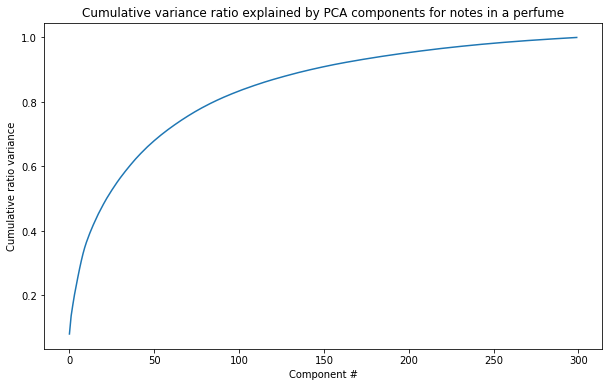

In [7]:
plt.subplots(figsize=(10, 6))
plt.plot(notes_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for notes in a perfume');

In [8]:
notes_pca_x = notes_pca.transform(notes_columns)

In [9]:
notes_pca_x.shape

(47648, 300)

In [10]:
notes_pca_selected_x = pd.DataFrame(notes_pca_x[:,:100])

In [11]:
notes_pca_selected_x.shape

(47648, 100)

Let's pick up only the top 100 PCA columns.

In [12]:
loadings = pd.DataFrame(notes_pca.components_.T, index=df.columns[0:-1])
loadings

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
musk,-0.094052,0.443414,-0.593046,0.483178,0.055082,0.357836,0.148941,-0.080370,-0.085290,0.017582,...,-0.000782,0.000103,-0.000448,0.000700,0.000148,0.000164,-0.000373,0.000561,0.000318,-0.000965
sandalwood,-0.062925,0.378746,0.126419,-0.113320,0.736658,-0.365606,0.061511,-0.308910,-0.112953,-0.114556,...,-0.000557,0.000885,-0.000904,0.000417,-0.000228,0.000253,-0.000379,-0.001101,0.000021,0.000717
jasmine,-0.106330,0.430112,-0.050456,-0.421082,-0.198914,0.037416,-0.342868,0.369522,-0.431375,-0.210785,...,0.001233,-0.000303,0.000128,0.001150,0.000358,-0.000968,0.000305,-0.001368,0.000837,-0.000585
amber,-0.061760,0.298833,0.102919,0.374825,-0.482427,-0.701983,0.131926,0.015483,0.005760,-0.018822,...,-0.000296,0.000746,0.000482,-0.000128,-0.000699,0.001132,0.000075,-0.000046,0.000066,0.000083
patchouli,-0.033467,0.193300,0.553954,0.144054,-0.239173,0.417637,0.013443,-0.439422,-0.229666,-0.266696,...,-0.000627,0.001051,0.000830,-0.000206,-0.000406,-0.000795,0.000813,-0.000685,-0.000054,-0.000670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
clover,0.001410,-0.000215,-0.000162,0.000031,0.000073,-0.001103,-0.001031,0.000055,-0.000841,0.001870,...,-0.198423,-0.132273,0.277932,0.317191,0.687755,-0.268271,-0.225081,0.061089,0.209799,0.069522
sea_salt,0.001702,-0.000899,-0.001141,0.001202,0.000475,0.000409,-0.000659,0.000928,-0.000654,0.000832,...,-0.217718,-0.217026,0.298952,-0.210962,-0.151443,-0.060192,0.344979,-0.231764,0.424217,0.533000
rice,-0.000113,-0.000945,-0.001267,-0.001205,0.000421,-0.000517,-0.000434,-0.000947,0.000825,0.000517,...,-0.051172,0.193250,0.523393,0.434226,-0.010128,0.436170,0.359938,-0.199284,-0.181873,-0.230823
red_rose,0.001162,0.000547,-0.000033,-0.000601,0.000187,-0.000852,0.001648,-0.000740,-0.001874,-0.000561,...,0.436571,-0.238247,0.142004,0.142859,-0.110549,-0.054530,0.317609,0.555932,0.354945,-0.178062


## 4.5 Train/Test Split<a id='4.5_Train/Test_Split'></a>

What partition sizes would you have with a 75/25 train/test split?

In [13]:
len(df) * .75, len(df) * .25

(35736.0, 11912.0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(notes_pca_selected_x,   # df.drop(columns='label')
                                                    df.label, test_size=0.25, 
                                                    random_state=47)

In [15]:
X_train.shape, X_test.shape

((35736, 100), (11912, 100))

In [16]:
y_train.shape, y_test.shape

((35736,), (11912,))

In [17]:
#Code task 2#
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
95    float64
96    float64
97    float64
98    float64
99    float64
Length: 100, dtype: object

In [18]:
#Code task 3#
#Repeat this check for the test split in `X_test`
X_test.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
95    float64
96    float64
97    float64
98    float64
99    float64
Length: 100, dtype: object

You have only numeric features in your X now!

## 4.6 Base Model - Decision Tree Classifier<a id='4.6_Decision_Tree'></a>

Let's start our classificaiton with the good old `DecisionTreeClassifier`.

In [19]:
# param_grid = {'max_depth': np.arange(1, 15)}

# dtree_model = DecisionTreeClassifier()
# dtree_cv = GridSearchCV(dtree_model, param_grid, cv=5)
# dtree_cv.fit(X_train, y_train)
# dtree_cv.best_params_

In [20]:
best_dtree_model = DecisionTreeClassifier(max_depth=6, random_state=0)
best_dtree_model.fit(X_train, y_train)
dt_y_pred = best_dtree_model.predict(X_test)

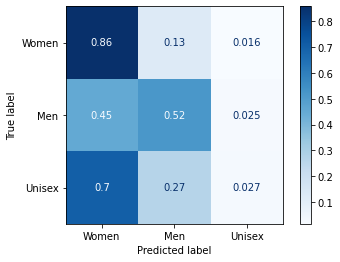

In [21]:
plot_confusion_matrix(best_dtree_model, X_test, y_test, display_labels=['Women', 'Men', 'Unisex'], cmap='Blues', normalize='true')
plt.show();

Evaluate the classifcation report.

In [22]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       0.60      0.86      0.70      5992
           1       0.48      0.52      0.50      2787
           2       0.34      0.03      0.05      3133

    accuracy                           0.56     11912
   macro avg       0.47      0.47      0.42     11912
weighted avg       0.50      0.56      0.48     11912



This model is not good at classifying 'men' and 'unisex' genders. It does an absymal job with the 'unisex' gender.

Let us keep this as a base model and try out other samples.

## 4.7 Initial Models<a id='4.7_Initial_Models'></a>

### 4.7.1 KNN Model<a id='4.7.1_KNN'></a>

In [23]:
# param_grid = {'n_neighbors': np.arange(1, 5)}

# knn_model = KNeighborsClassifier() 
# knn_cv = GridSearchCV(knn_model, param_grid, cv=5)
# knn_cv.fit(X_train, y_train)
# knn_cv.best_params_

In [24]:
best_knn_model = KNeighborsClassifier(n_neighbors=5)

best_knn_model.fit(X_train, y_train)
knn_y_pred = best_knn_model.predict(X_test)

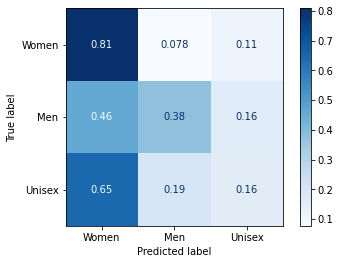

In [25]:
plot_confusion_matrix(best_knn_model, X_test, y_test, display_labels=['Women', 'Men', 'Unisex'], cmap='Blues', normalize='true')
plt.show();

In [26]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68      5992
           1       0.50      0.38      0.43      2787
           2       0.30      0.16      0.21      3133

    accuracy                           0.54     11912
   macro avg       0.46      0.45      0.44     11912
weighted avg       0.49      0.54      0.50     11912



### 4.7.2 Random Forest Model<a id='4.7.2_Random_Forest'></a>

In [ ]:
n_est = [int(n) for n in np.logspace(start=2, stop=3, num=10)]

param_grid = {'n_estimators': n_est}

rf_model = RandomForestClassifier()
rf_cv = GridSearchCV(rf_model, param_grid, cv=5)
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

In [20]:
best_rf_model = RandomForestClassifier(n_estimators=100)
best_rf_model.fit(X_train, y_train)
rf_y_pred = best_rf_model.predict(X_test)

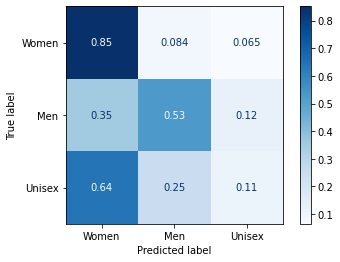

In [22]:
plot_confusion_matrix(best_rf_model, X_test, y_test, display_labels=['Women', 'Men', 'Unisex'], cmap='Blues', normalize='true')
plt.show();

In [23]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.63      0.85      0.72      5992
           1       0.54      0.53      0.53      2787
           2       0.32      0.11      0.17      3133

    accuracy                           0.58     11912
   macro avg       0.50      0.50      0.47     11912
weighted avg       0.53      0.58      0.53     11912



### 4.7.3 AdaBoost Model<a id='4.7.3_Adaboost'></a>

In [24]:
n_est = [int(n) for n in np.logspace(start=1, stop=2, num=10)]

param_grid = {'n_estimators': n_est}

ab_model = AdaBoostClassifier(n_estimators=100)
ab_cv = GridSearchCV(rf_model, param_grid, cv=5)
ab_cv.fit(X_train, y_train)
ab_cv.best_params_

{'n_estimators': 100}

In [23]:
best_ab_model = RandomForestClassifier(n_estimators=100)
best_ab_model.fit(X_train, y_train)
rf_y_pred = best_ab_model.predict(X_test)

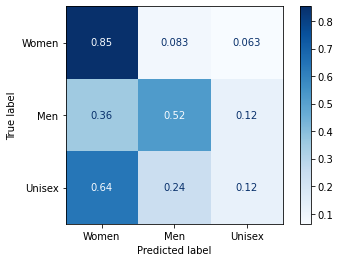

In [24]:
plot_confusion_matrix(best_ab_model, X_test, y_test, display_labels=['Women', 'Men', 'Unisex'], cmap='Blues', normalize='true')
plt.show();

In [25]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.63      0.85      0.73      5992
           1       0.54      0.52      0.53      2787
           2       0.35      0.12      0.18      3133

    accuracy                           0.58     11912
   macro avg       0.51      0.50      0.48     11912
weighted avg       0.53      0.58      0.54     11912



### 4.7.4 Logisitic Regression Model<a id='4.7.4_Logistic_Regression'></a>

In [24]:
n_est = [int(n) for n in np.logspace(start=1, stop=2, num=10)]

param_grid = {'n_estimators': n_est}

ab_model = LogisticRegression(C=1e5)
ab_cv = GridSearchCV(rf_model, param_grid, cv=5)
ab_cv.fit(X_train, y_train)
ab_cv.best_params_

{'n_estimators': 100}

In [31]:
best_lr_model = LogisticRegression(random_state=0)
best_lr_model.fit(X_train, y_train)
lr_y_pred = best_lr_model.predict(X_test)

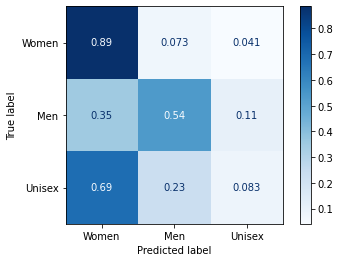

In [29]:
plot_confusion_matrix(best_lr_model, X_test, y_test, display_labels=['Women', 'Men', 'Unisex'], cmap='Blues', normalize='true')
plt.show();

In [32]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74      5992
           1       0.56      0.54      0.55      2787
           2       0.32      0.08      0.13      3133

    accuracy                           0.59     11912
   macro avg       0.51      0.50      0.47     11912
weighted avg       0.53      0.59      0.53     11912



### 4.7.5 SVC Model<a id='4.7.5_SVM'></a>

In [33]:
best_sv_model = SVC()
best_sv_model.fit(X_train, y_train)
sv_y_pred = best_sv_model.predict(X_test)

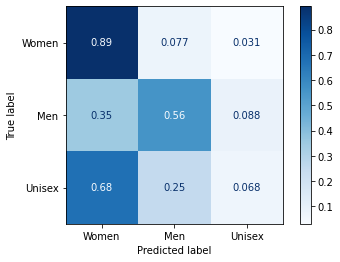

In [34]:
plot_confusion_matrix(best_sv_model, X_test, y_test, display_labels=['Women', 'Men', 'Unisex'], cmap='Blues', normalize='true')
plt.show();

In [35]:
print(classification_report(y_test, sv_y_pred))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74      5992
           1       0.55      0.56      0.56      2787
           2       0.33      0.07      0.11      3133

    accuracy                           0.60     11912
   macro avg       0.51      0.51      0.47     11912
weighted avg       0.54      0.60      0.53     11912



## 4.8 Summary<a id='4.8_Summary'></a>

All the models are failing in identifying the 'unisex' class. 